In [2]:
import os
import random
import numpy as np
import json
import io
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import boto3

2023-05-30 17:13:49.661919: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 17:13:49.877300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 17:13:49.879918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 17:13:52.092653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load the configuration file
with open('config.json') as json_file:
    config = json.load(json_file)


In [4]:
# Create a boto3 resource and get the bucket
s3 = boto3.resource(
    's3',
    aws_access_key_id=config["AWS_access_key_id"],
    aws_secret_access_key=config["AWS_secret_access_key"],
)
bucket = s3.Bucket(config["AWS_bucket_name"])


In [5]:
# Load the trained model
model = load_model('classification_model.h5')


In [12]:
def display_new_images_with_probabilities(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 4))
    for idx, image_file in enumerate(images):
        obj = bucket.Object(config["AWS_input_folder_name"] + "/" + image_file)
        try:
            response = obj.get()
            img_data = response['Body'].read()  # save the image data for later use
            img = Image.open(io.BytesIO(img_data))
            image_file_name = obj.key.split('/')[-1]  # get the original file name from the S3 key
        except Exception as e:
            print(f"Cannot identify image file: {image_file}")
            print("Exception: ", e)
            continue

        img = img.resize((224, 224)) # Resize image to match model's expected input
        img_array = np.array(img) / 255.0 # Model was trained on images scaled to [0,1]
        img_array = np.expand_dims(img_array, axis=0) # Model expects batches of images

        prediction = model.predict(img_array)[0][0]
        prediction_percentage = (1 - prediction) * 100 # Since all images are 'trees'

        axes[idx].imshow(img)
        axes[idx].set_title(f"Tree - {prediction_percentage:.2f}%")
        axes[idx].axis('off')

        # Save the image in the corresponding folder based on the predicted class
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()

        # Save the original image in the corresponding folder based on the predicted class
        if prediction < 0.5:  # The threshold can be adjusted based on your needs
            bucket.put_object(Body=img_data, Key=config["AWS_trees_folder_name"] + "/" + image_file_name)
        else:
            bucket.put_object(Body=img_data, Key=config["AWS_plastic_folder_name"] + "/" + image_file_name)
    plt.tight_layout()
    plt.show()


In [13]:

# Get all image files from the 'new-batch' directory
objs = bucket.objects.filter(Prefix=config["AWS_input_folder_name"] + "/")
sample_pics = [obj.key.split("/")[-1] for obj in objs]


Cannot identify image file: 
Exception:  cannot identify image file <_io.BytesIO object at 0x7f2bd066e7a0>
1/1 [==============================] - 0s 54ms/step


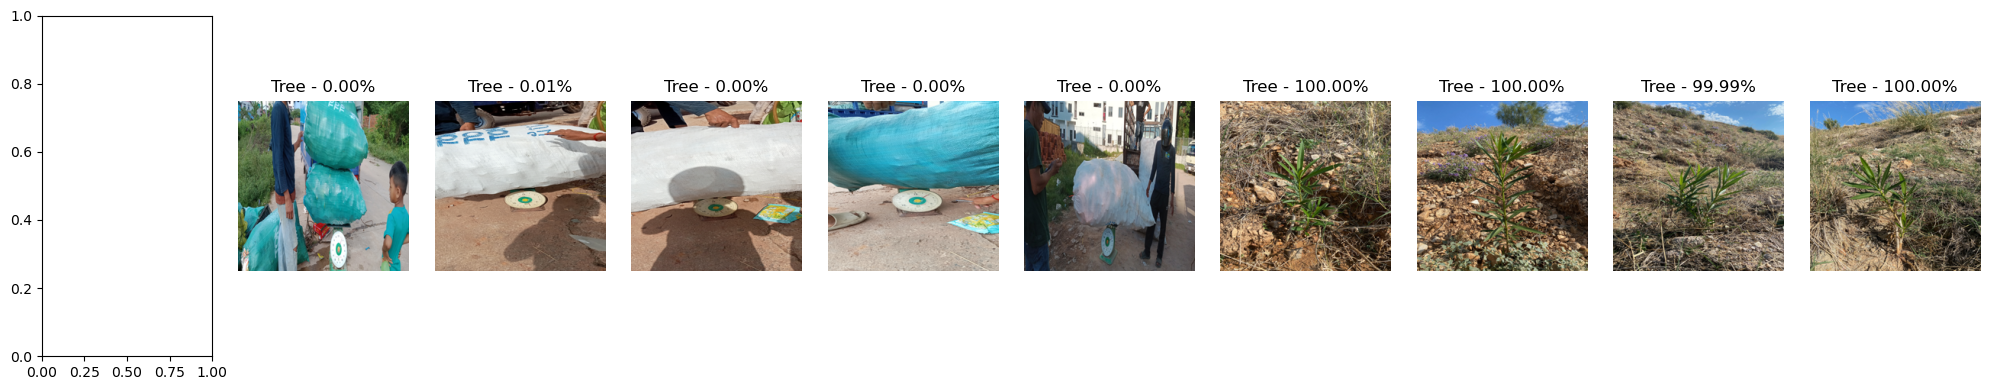

In [14]:

# Display new images with their predicted probabilities
display_new_images_with_probabilities(sample_pics)